## Run if using Google Colab

In [2]:
!pip install pyvis
!pip install geopy

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/Cours 3A/Projet 3A/Challenge Alstom - IA PAU'

/content/drive/MyDrive/Cours 3A/Projet 3A/Challenge Alstom - IA PAU


## Imports

In [33]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import random
from itertools import chain
import geopy.distance
import numpy as np
from copy import deepcopy

## Network plan

In [87]:
df_network_plan = pd.read_csv('plan du métro.csv')
df_network_plan.info()
df_network_plan.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   de Ligne      1010 non-null   object
 1   de Station    1010 non-null   object
 2   vers Ligne    1010 non-null   object
 3   vers Station  1010 non-null   object
dtypes: object(4)
memory usage: 31.7+ KB


,de Ligne,de Station,vers Ligne,vers Station
0,1,Charles de Gaulle - Étoile,2,Charles de Gaulle - Étoile
1,1,Charles de Gaulle - Étoile,6,Charles de Gaulle - Étoile
2,1,Franklin D. Roosevelt,9,Franklin D. Roosevelt
3,1,Champs-Élysées - Clemenceau,13,Champs-Élysées - Clemenceau
4,1,Concorde,8,Concorde


In [88]:
#removing inter-station where target corresponds to a tramway station
df_network_plan = df_network_plan[~df_network_plan['vers Ligne'].isin(['\xa01', '\xa07', '\xa02', '\xa08', '\xa06'])]

In [89]:
df_network_plan['vers Ligne'].unique()

array(['2', '6', '9', '13', '8', '12', '7', '4', '11', '14', '5', '1',
       '3', '10', '3bis', '7bis'], dtype=object)

In [78]:
print(set(df_network_plan['vers Ligne'].unique()) == set(df_network_plan['de Ligne'].unique()))

True


In [79]:
print(set(df_network_plan['vers Station'].unique()) == set(df_network_plan['de Station'].unique()))

True


In [90]:
df_position = pd.read_csv('position gps des stations de métro.csv')
df_position.info()
print(df_position.head())

#Removing Malsesherbes RER Station
df_position = df_position.drop([151])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Station  386 non-null    object
 1   GPS      386 non-null    object
dtypes: object(2)
memory usage: 6.2+ KB
      Station                                    GPS
0   Boucicaut   48.84109405724891, 2.287945766487378
1      Bourse  48.86865415183625, 2.3413760511435733
2  Bir-Hakeim  48.85394260621378, 2.2893345327788075
3   Argentine  48.87533684211653, 2.2901275088247015
4   Daumesnil  48.83954964556868, 2.3957032894363937


In [91]:
network_stations = {station : {} for station in df_network_plan['de Station'].unique()}
reverse_network_stations = {}

# unique (station, line) couples that we're using as nodes in our graph
df_nodes = df_network_plan.groupby(['de Station','de Ligne']).size().reset_index().rename(columns={0:'count'})

count=0
for node in df_nodes.values:

  network_stations[node[0]].update({node[1] : count})
  reverse_network_stations.update({count : {'title' : node[0], 'group' :node[1]}})
  count+=1

In [84]:
for node, attr in reverse_network_stations.items():
    if "bis" in attr['group']:
        print(node, attr['title'])

36 Bolivar
39 Botzaris
46 Buttes Chaumont
99 Danube
122 Gallieni
124 Gambetta
155 Jaurès
184 Louis Blanc
196 Mairie d'Ivry
257 Pelleport
272 Place des Fêtes
307 Porte des Lilas
309 Pré-Saint-Gervais


In [92]:
unspecified_loc_nodes = []
for station, station_lines in network_stations.items():
  df_coords = df_position[df_position['Station'] == station]
  if not df_coords.empty:
    complete_gps = []
    if len(station_lines.values()) - len(df_coords['GPS'].values) > 0:
      for _ in range(len(station_lines.values()) - len(df_coords['GPS'].values)):
        complete_gps.append(random.choice(df_coords['GPS'].values))

    for coord, node_station in zip([*df_coords['GPS'].values, *complete_gps], station_lines.values()):
      lat, lon = coord.split(', ')
      lat, lon = float(lat), float(lon)
      reverse_network_stations[node_station].update({'lon':lon, 'lat':lat})
  else:
    unspecified_loc_nodes = [*unspecified_loc_nodes, *station_lines.values()]

In [93]:
edges = []
for edge in df_network_plan.values:
  edges.append((network_stations[edge[1]][edge[0]], network_stations[edge[3]][edge[2]]))

In [11]:
def get_node_neighbors(G, node, distance=1):
  if distance == 1:
    neighbors = list(G.neighbors(node))
    return neighbors
  else:
    neighbors = list(G.neighbors(node))
    total_neighbors = [neighbors.copy()]
    for neighbor in neighbors:
      total_neighbors.append(get_node_neighbors(G, neighbor, distance-1))
    total_neighbors = list(chain(*total_neighbors))
    return list(set(total_neighbors))
    # return list(chain(*total_neighbors))

In [136]:
network_graph = nx.DiGraph()
network_graph.add_edges_from(edges)
# nx.set_node_attributes(network_graph, reverse_network_stations)

In [95]:
min_dist = 3
max_dist = 3
unspecified_loc_nodes_pos = {}
for node_station in unspecified_loc_nodes:
  mean_lat, mean_lon = [], []
  for dist in range(min_dist,max_dist+1):
    for neighbor in get_node_neighbors(network_graph, node_station, distance=dist):

      lon = reverse_network_stations[neighbor].get('lon')
      lat = reverse_network_stations[neighbor].get('lat')
      if lon is not None and lat is not None:
        mean_lat.append(lat)
        mean_lon.append(lon)

    if len(mean_lat) > 0 and len(mean_lon) > 0:
      unspecified_loc_nodes_pos.update({node_station : {'lon' : sum(mean_lon)/len(mean_lon), 'lat': sum(mean_lat)/len(mean_lat)}})
      break
    else:
      print(node_station)
      continue
nx.set_node_attributes(network_graph, unspecified_loc_nodes_pos)

## Adding edge weight based on distance between stations

In [96]:
for edge in network_graph.edges:
  start_node = network_graph.nodes[edge[0]]
  end_node = network_graph.nodes[edge[1]]
  distance = geopy.distance.geodesic((start_node['lat'], start_node['lon']), (end_node['lat'], end_node['lon'])).km
  network_graph.edges[edge]['inv_dist_km'] = 1/distance if distance != 0 else 1.0

## Network visualization

### With `pyvis`



In [ ]:
# from IPython.display import display, HTML

# net_viz = Network(directed=True, notebook=True, cdn_resources='in_line')
net_viz = Network(directed=True)
net_viz.from_nx(network_graph)
net_viz.save_graph('viz/network_graph_test.html')
# net_viz.show('viz/network_graph_test.html')



# html = net_viz.generate_html()
# with open("example.html", mode='w', encoding='utf-8') as fp:
#     fp.write(html)
# display(HTML(html))

### Using `networkx` API

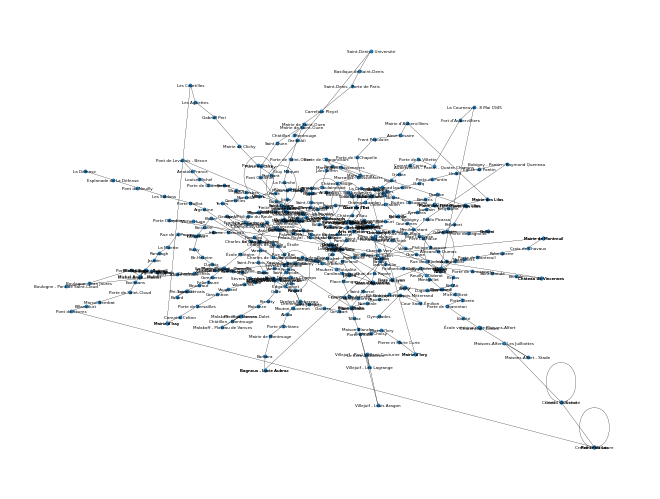

In [97]:
pos = {node_idx : (node['lon'], node['lat']) for node_idx, node in network_graph.nodes.items()}

nx.draw(network_graph, node_size=3, width=0.1, arrowsize=0.2, pos=pos, labels=nx.get_node_attributes(network_graph, 'title'), font_size=3)
#

## Flow for each path

In [98]:
df_flow = pd.read_csv('passagers.csv')
df_flow.info()
df_flow.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93942 entries, 0 to 93941
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   de      93942 non-null  object
 1   vers    93942 non-null  object
 2   nombre  93942 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


,de,vers,nombre
0,La Défense,Esplanade de La Défense,7
1,La Défense,Pont de Neuilly,5
2,La Défense,Les Sablons,6
3,La Défense,Porte Maillot,6
4,La Défense,Argentine,5


In [102]:
def get_best_path(network_stations, start_station, end_station):
  lb_path_weight = 0
  best_path = None
  for start_node in network_stations[start_station].values():
    for end_node in network_stations[end_station].values():
      try:
        current_path = nx.dijkstra_path(network_graph, start_node, end_node, weight='inv_dist_km')
        current_path_weight = sum([network_graph.edges[edge]['inv_dist_km'] for edge in zip(current_path[:-1], current_path[1:])])
        if current_path_weight > lb_path_weight:
          lb_path_weight = current_path_weight
          best_path = current_path
      except nx.NetworkXNoPath:
        print(f"Could not find a path between {reverse_network_stations[start_node]['title']} (line {reverse_network_stations[start_node]['group']}) \
              and {reverse_network_stations[end_node]['title']} (line {reverse_network_stations[end_node]['group']})")
  return best_path

path_idx = np.random.randint(0, len(df_flow))
test_path = df_flow.iloc[path_idx]
print(test_path)
# start_station = 'Gallieni'
start_station = test_path['de']
end_station = 'Gallieni'
# end_station = test_path['vers']
flow = test_path['nombre']

best_path = get_best_path(network_stations, start_station, end_station)
print(" ->\n".join([f'{reverse_network_stations[node]["title"]} ({reverse_network_stations[node]["group"]})' for node in best_path]))

de                           Carrefour Pleyel
vers      Villejuif - Paul Vaillant-Couturier
nombre                                      9
Name: 87678, dtype: object
Could not find a path between Carrefour Pleyel (line 13)               and Gallieni (line 3bis)
Carrefour Pleyel (13) ->
Mairie de Saint-Ouen (13) ->
Mairie de Saint-Ouen (14) ->
Saint-Ouen (14) ->
Porte de Clichy (14) ->
Pont Cardinet (14) ->
Saint-Lazare (14) ->
Madeleine (14) ->
Pyramides (14) ->
Châtelet (14) ->
Châtelet (7) ->
Châtelet (11) ->
Hôtel de Ville (11) ->
Rambuteau (11) ->
Arts et Métiers (11) ->
République (11) ->
République (3) ->
Parmentier (3) ->
Rue Saint-Maur (3) ->
Père Lachaise (3) ->
Gambetta (3) ->
Porte de Bagnolet (3) ->
Gallieni (3)


In [130]:
test_multi_station = {k : v for k,v in network_stations.items() if len(v)>1}
for station, lines in test_multi_station.items():
    station_nodes = list(lines.values())
    station_lines = list(lines.keys())
    if len(station_nodes) > 1:
        for i in range(len(station_nodes)):
            for j in range(i+1,len(station_nodes)):
                if not (network_graph.has_edge(station_nodes[i], station_nodes[j]) and  network_graph.has_edge(station_nodes[j], station_nodes[i])):
                    print(f'{station_nodes[i]} ({station} {station_lines[i]}) - {station_nodes[j]} ({station} {station_lines[j]})')


233 (Nation 1) - 235 (Nation 3)
233 (Nation 1) - 237 (Nation 7)
234 (Nation 2) - 235 (Nation 3)
234 (Nation 2) - 237 (Nation 7)
235 (Nation 3) - 236 (Nation 6)
235 (Nation 3) - 237 (Nation 7)
235 (Nation 3) - 238 (Nation 9)
236 (Nation 6) - 237 (Nation 7)
237 (Nation 7) - 238 (Nation 9)
153 (Jaurès 2) - 155 (Jaurès 7bis)
154 (Jaurès 5) - 155 (Jaurès 7bis)
123 (Gambetta 3) - 124 (Gambetta 3bis)
306 (Porte des Lilas 11) - 307 (Porte des Lilas 3bis)
306 (Porte des Lilas 11) - 308 (Porte des Lilas 4)
307 (Porte des Lilas 3bis) - 308 (Porte des Lilas 4)
125 (Gare d'Austerlitz 10) - 126 (Gare d'Austerlitz 11)
126 (Gare d'Austerlitz 11) - 127 (Gare d'Austerlitz 5)
183 (Louis Blanc 7) - 184 (Louis Blanc 7bis)
271 (Place des Fêtes 11) - 272 (Place des Fêtes 7bis)
70 (Château de Vincennes 1) - 71 (Château de Vincennes 2)
121 (Gallieni 3) - 122 (Gallieni 3bis)
14 (Bagneux - Lucie Aubrac 4) - 15 (Bagneux - Lucie Aubrac 5)
195 (Mairie d'Ivry 7) - 196 (Mairie d'Ivry 7bis)
309 (Pré-Saint-Gervais 7bis

In [105]:
network_graph.has_edge(122, 121)

False

In [113]:
def get_nodes_traffic(network_graph, df_flow):
  nodes_traffic = {node_idx : {'traffic' : 0} for node_idx in network_graph.nodes}
  for path_idx in range(len(df_flow)):
    path = df_flow.iloc[path_idx]
    start_station = path['de']
    end_station = path['vers']
    flow = path['nombre']
    best_path = get_best_path(network_stations, start_station, end_station)
    if best_path is not None:
      for node in best_path:
        nodes_traffic[node]['traffic'] += flow
  return nodes_traffic

nodes_traffic = get_nodes_traffic(network_graph, df_flow)
# nodes_traffic

Could not find a path between La Défense (line 1)               and Jaurès (line 7bis)
Could not find a path between La Défense (line 1)               and Gambetta (line 3bis)
Could not find a path between La Défense (line 1)               and Gallieni (line 3bis)
Could not find a path between La Défense (line 1)               and Pelleport (line 3bis)
Could not find a path between La Défense (line 1)               and Porte des Lilas (line 3bis)
Could not find a path between La Défense (line 1)               and Louis Blanc (line 7bis)
Could not find a path between La Défense (line 1)               and Mairie d'Ivry (line 7bis)
Could not find a path between La Défense (line 1)               and Bolivar (line 7bis)
Could not find a path between La Défense (line 1)               and Buttes Chaumont (line 7bis)
Could not find a path between La Défense (line 1)               and Botzaris (line 7bis)
Could not find a path between La Défense (line 1)               and Danube (line 7bis)
Cou

In [114]:
total_trafic = sum([node['traffic'] for node in nodes_traffic.values()])
print(total_trafic)
normalized_nodes_traffic = {node_idx : {'traffic' : node['traffic']/total_trafic} for node_idx, node in nodes_traffic.items()}
# normalized_nodes_traffic

7967143


In [115]:
nx.set_node_attributes(network_graph, normalized_nodes_traffic)

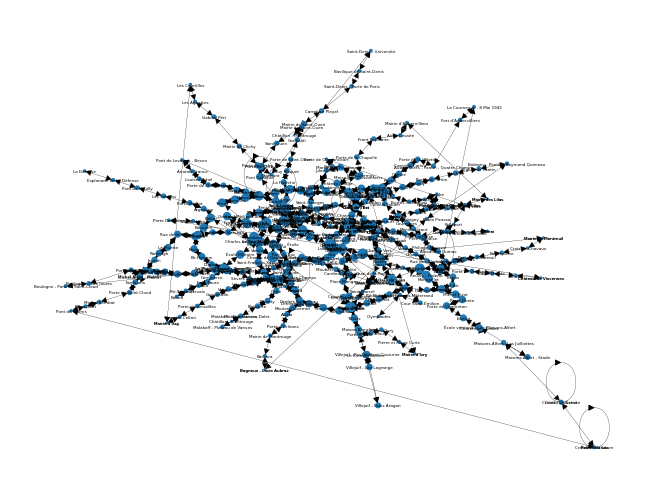

In [116]:
node_size = [5000*node['traffic'] for node in network_graph.nodes.values()]
pos = {node_idx : (node['lon'], node['lat']) for node_idx, node in network_graph.nodes.items()}

nx.draw(network_graph, node_size=node_size, width=0.1, pos=pos, labels=nx.get_node_attributes(network_graph, 'title'), font_size=3)

## Creating degraded network from initial

In [120]:
def get_degraded_network(network_graph: nx.Graph, num_delete=10):
    degraded_graph = network_graph.copy()
    graph_edges = deepcopy(list(network_graph.edges))
    for i in range(num_delete):
        is_deletable = False
        while not is_deletable:
            deleted_edge = random.choice(graph_edges)
            # print(deleted_edge)
            simple_paths = [simple_path for simple_path in nx.all_simple_paths(degraded_graph, deleted_edge[0], deleted_edge[1], cutoff=5)]
            # print(len(simple_paths))
            if len(simple_paths) > 1:
                degraded_graph.remove_edge(deleted_edge[0], deleted_edge[1])
                graph_edges.remove(deleted_edge)
                is_deletable = True
                print("Deleted", deleted_edge)
        
    return degraded_graph

In [126]:
degraded_network = get_degraded_network(network_graph)
print(len(network_graph.edges))
print(len(degraded_network.edges))

Deleted (73, 187)
Deleted (249, 191)
Deleted (371, 37)
Deleted (113, 255)
Deleted (23, 21)
Deleted (230, 108)
Deleted (267, 268)
Deleted (149, 148)
Deleted (190, 191)
Deleted (75, 76)
1002
992
